# Solving the 1-D transport equation with MPS
This notebook numerically solve the 1-D transport equations given by
$$\frac{\delta \rho}{\delta t} = -\frac{\delta }{\delta x} (u \rho).$$
For simplicity, we assume $u$ to be constant in time.

#### This notebook contains:
* the intilization and discretization of $u$ and $\rho$
* the discretization of the spatial derivative using a finite difference matrix $F$
* the discretization of the temporal derivative using an euler stepping scheme
* naive numerical solution
* decomposition of $u$, $\rho$ and $F$ into MPS, MPO respectively
* MPS/MPO base solution

## Initial Values

We choose a simple initial Values:
* gaussian for the density field $\rho$
* squared sine wave for the velocity $u$

In [1]:
import numpy as np

# Define Gaussian and sine function
def gaussian(x, mu, sigma):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma)**2)

def sine_squared(x, mu, offset):
    return np.sin(2 * np.pi * (x_values - mu))**2 + offset

# resolution
n = 7
N = 2**n

# x values from 0 to 1
x_values = np.linspace(0, 1, N)

# Mean (peak) in the middle
mu = 0.5

# linear velocity offset
offset = 0.5

# Standard deviation (adjust for desired width)
sigma = 0.1

# Generate Arrays with initial values
rho_initial = gaussian(x_values, mu, sigma)
u_initial = sine_squared(x_values, mu, offset)

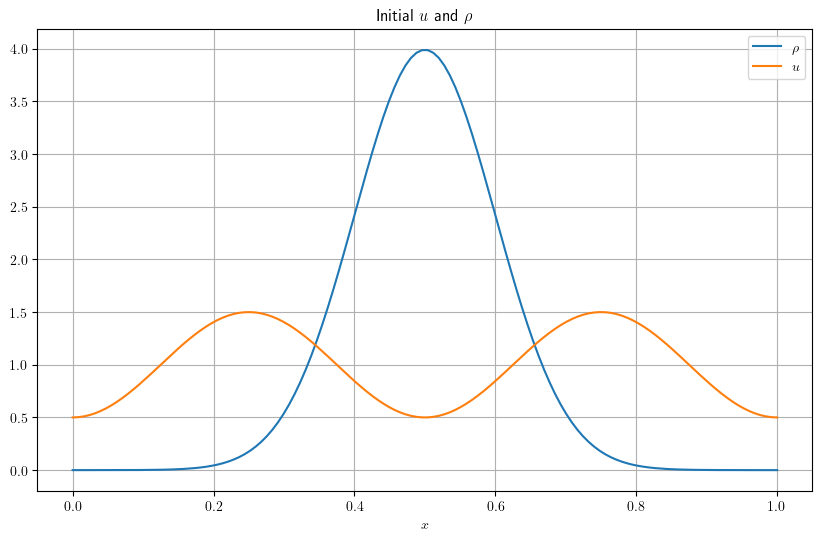

In [2]:
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x_values, rho_initial, label=r'$\rho$')
plt.plot(x_values, u_initial, label=r'$u$')

# Customize the plot
plt.xlabel(r'$x$')
plt.title(r'Initial $u$ and $\rho$')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


## Discretization of the Spatial Derivative
To discretize the spatial derivative we apply the following:
* 8th order finite difference
* set up as an $N \times N$ matrix $F$
* periodic boundary conditions

In [3]:
from findiff import coefficients

# generate coefficients
order = 8
coefficients = coefficients(deriv=1, acc=order)['center']['coefficients']
print(f"First derivative coefficients for accuracy order {order}: {coefficients}")

# fill matrix F
matrices = [np.identity(N) for i in range(len(coefficients))]
for i in range(len(matrices)):
  matrices[i] *= coefficients[i]*N
  matrices[i] = np.roll(matrices[i], i-int(order/2), axis=1)
F = np.sum(matrices, axis=0)


First derivative coefficients for accuracy order 8: [ 3.57142857e-03 -3.80952381e-02  2.00000000e-01 -8.00000000e-01
 -4.84636298e-15  8.00000000e-01 -2.00000000e-01  3.80952381e-02
 -3.57142857e-03]


## Discretization of the Temporal Derivative
We apply a simple euler stepping scheme to discretize time.
$$\rho_{t+1} = \rho_t - h F(u \otimes \rho_t)$$

In [4]:
# define function for euler time step
def advance_time(rho, u, dt):
  rho_next = rho - dt * F.dot(u*rho)
  return rho_next

In [5]:
# integrate the initial values
t_total = 1.17

rho_next = rho_initial
dt = .1/(order*N)
steps = int(t_total/dt)
data = []
for i in range(steps):
  rho_next = advance_time(rho_next, u_initial, dt)
  if i%100 == 0:
    data.append(rho_next)

# Animation of the Naive Solution

In [6]:
import matplotlib.animation as animation
from IPython.display import HTML

# Create the animation
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_ylim([0, 4.9])

line, = ax.plot(x_values, data[0], label=r'$\rho$')

def animate(i):
    line.set_ydata(data[i])  # Update the data
    return line,

ani = animation.FuncAnimation(fig, animate, frames=len(data), blit=True, interval=30, repeat=False)

ax.plot(x_values, u_initial, label=r'$u$')
plt.xlabel(r'$x$')
plt.legend()
plt.grid(True)
plt.title(r'Naive Solution')
plt.close()

# render the animation
HTML(ani.to_html5_video())

## Decomposition of Fields
We decompose both $u$ and $\rho$ into an $n$-Site MPS.

In [7]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from utils.jax_ops import *

# define the maximum bond dimension
chi_max = 2**(int(n/2))

# reshape arrays with binary indices
reshaped_rho = rho_initial.reshape((2,)*n)
reshaped_u = u_initial.reshape((2,)*n)

# decompose into MPS
jax_rho_initial = MPS(reshaped_rho, max_bond=chi_max)
jax_u = MPS(reshaped_u, max_bond=chi_max)

## Generation of MPO Cores for Finite Differences

generate the necessary cores of the finite difference MPO and the Kronecker delta used in elementwise multiplication.

In [8]:
from utils.mpos import diff_cores, kron_delta

# generate MPO cores representing the finite difference operator
mpo_F = diff_cores(1,0,n,1, delta_x=1/N)

# initialize kronecker deltas to be used in the hadamard (elemtentwise) product
kron = kron_delta(2)

# cast numpy arrays to jnp arrays
jax_F = list_to_jnp(mpo_F)
jax_kron = jnp.array(kron)

## Rewriting the Euler Step

In [9]:
# rewrite euler time step using MPS/MPO operations
def mps_advance_time(rho, u, dt):
  delta = multiply_MPS_MPS(jax_kron, rho, u)    # multiply rho and u elementwise
  delta = apply_MPO(jax_F, delta)               # apply finite difference MPO
  delta[0] = - dt * delta[0]                    # multiply by scalar -dt
  rho_next = add_MPS_MPS(rho, delta)            # add the "delta" to the old state
  compress_MPS(rho_next, chi_max)               # compress new state down to chi_max
  return compress_MPS(rho_next, chi_max)        # return the new state

jit_advance_time = jax.jit(mps_advance_time)    # compile time step to speed up computation

## Time Integration and Animation

In [10]:
rho_next = jax_rho_initial
mps_data = []
for i in range(steps):
  rho_next = jit_advance_time(rho_next, jax_u, dt)
  if i%100 == 0:
    print("at", int(i*100/steps), "percent", end="\r")
    mps_data.append(contract_MPS(rho_next).reshape((N)))
print("finished!              ", end="\r")

In [11]:
import matplotlib.animation as animation
from IPython.display import HTML

# Create the animation
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_ylim([0, 4.9])

line, = ax.plot(x_values, data[0], label=r'$\rho$')

def animate(i):
    line.set_ydata(mps_data[i])  # Update the data
    return line,

ani = animation.FuncAnimation(fig, animate, frames=len(data), blit=True, interval=30, repeat=False)

ax.plot(x_values, u_initial, label=r'$u$')
plt.xlabel(r'$x$')
plt.legend()
plt.grid(True)
plt.title(r'MPS/MPO Solution')
plt.close()

# render the animation
HTML(ani.to_html5_video())